# How to use a Torchvision dataset in the Grain pipeline

In this tutorial we're going to learn how to migrate from the Torchvision to the Grain pipeline for the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

## Setup

Here we require `grain`, `torch`, and `torchvision` dependencies installed but the last will be used primarily for dataset access. Additionally we want `matplotlib` in our environment for displaying samples.

In [ ]:
%pip install grain
%pip install numpy matplotlib torch torchvision

In [4]:
import grain
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL.Image import Image

# PyTorch imports
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

rng = np.random.default_rng(0)

## Loading the dataset with Torchvision

The Torchvision `FashionMNIST` function provides access to our dataset. There are 60k samples in the dataset, where each one of them is a Pillow image instance together with a label.

In [5]:
fashion_mnist = datasets.FashionMNIST(root="data", train=True, download=True)
print(fashion_mnist)
print(fashion_mnist[0])
fashion_mnist[0][0]

100%|██████████| 26.4M/26.4M [00:00<00:00, 60.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.14MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 20.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
(<PIL.Image.Image image mode=L size=28x28 at 0x72BC7848F1F0>, 9)


In this example, we have an ankle boot (label 9). First we should acknowledge that both sample and label require dedicated preprocessing:
- The sample should be a PyTorch tensor;
- The label needs to use one-hot encoding, so `9` becomes `[0,0,0,0,0,0,0,0,0,1]`.

Let's inspect a few more samples first.

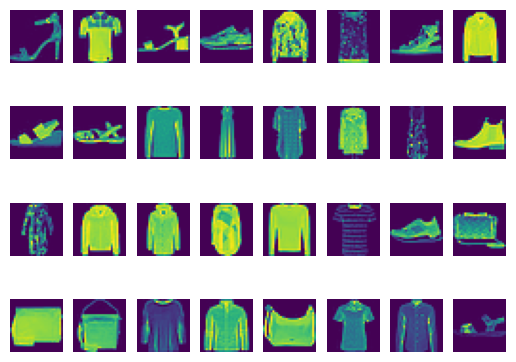

In [6]:
nrows, ncols = 4, 8
fig, axs = plt.subplots(nrows, ncols)
for x in range(ncols):
    for y in range(nrows):
        axs[y, x].imshow(fashion_mnist.data[rng.integers(len(fashion_mnist))])
        axs[y, x].set_axis_off()

`torchvision`'s `datasets` function, which imports the dataset, already offers `transform` and `target_transform` arguments. Let's confirm that `ToTensor` and `Lambda` do what we anticipate.

In [7]:
fashion_mnist_2 = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

In [8]:
(fashion_mnist_2[0][0].size(), fashion_mnist_2[0][1])

(torch.Size([1, 28, 28]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

The resulting contents are a PyTorch tensor and a one-hot encoded label, as expected.

## Processing the dataset with Grain

Now let's move to Grain! Our goal is perform the same transformation on the dataset as before, but this time using Grain API. You might have noticed in the [Dataset basics tutorial](https://google-grain.readthedocs.io/en/latest/tutorials/dataset_basic_tutorial.html) that defining a data source requires implementing a class that inherits from `grain.sources.RandomAccessDataSource`. With PyTorch datasets we don't need it - the dataset is already compliant with the protocol.

First let's define our data source with random access capabilities.

In [9]:
fashion_source = fashion_mnist

Next let's move to the preprocessing stage. We implement a custom class which inherits from `grain.transforms.Map` and implements a `map` method. In this method we instantiate a PyTorch tensor and devise a one-hot encoded label.

To make this rewrite more compelling, let's use Grain's capabilities beyond simple samples traversal. Assuming that we are interested in shoes only (labels: `5` - sandals, `7` - sneakers, and `9` - ankle boots) we implement a `Filter` class with a `filter` that allows us to discard unwanted samples.

In [10]:
class ToTensorAndOneHot(grain.transforms.Map):
    to_tensor = ToTensor()

    def map(self, element: tuple[Image, int]) -> tuple[torch.Tensor, torch.Tensor]:
        data = self.to_tensor(element[0])
        target = (
            torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(element[1]), value=1)
        )
        return (data, target)


class KeepShoesOnly(grain.transforms.Filter):
    shoes_only = {5, 7, 9}  # Sandal, Sneaker, Ankle boot

    def filter(self, element: tuple[Image, int]) -> bool:
        return element[1] in self.shoes_only

## Complete Pipeline

Now we combine all pieces into a single pipeline. Grain exposes an API that allows us to rely on a chain of method calls. This results in a straightforward flow from the source to the final batching stage.

In [11]:
dataset = (
    grain.MapDataset.source(fashion_source)
    .shuffle(seed=42)
    .filter(KeepShoesOnly())  # leave only shoes
    .map(ToTensorAndOneHot())  # construct tensors and label one-hot encoding
    .to_iter_dataset()
    .batch(  # batches consecutive elements
        batch_size=5,
        batch_fn=lambda ts: tuple(torch.stack(t) for t in zip(*ts)),
    )
)

The result is exactly what we expected - both samples and labels are now PyTorch tensors, and they're batched in groups of five.

In [12]:
iterator = iter(dataset)
batch_0 = next(iterator)
print(type(batch_0[0]), batch_0[0].shape)
print(batch_0[1])

<class 'torch.Tensor'> torch.Size([5, 1, 28, 28])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


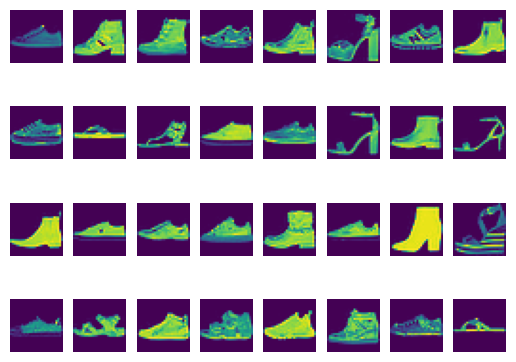

In [13]:
nrows, ncols = 4, 8
fig, axs = plt.subplots(nrows, ncols)
for x in range(ncols):
    data, _ = next(iterator)
    for y in range(nrows):
        axs[y, x].imshow(data[y, 0])
        axs[y, x].set_axis_off()

In the last cell we additionally confirm that all items are restricted to shoes only. The pipeline that we've built not only allowed us to ensure Torchvision dataset-loading features, but also extend with batching and filtering capabilities.